This is the notebook for the signal processing of a magnet signal in the lecture Sensors and Signal Processing.

In [2]:
#!pip install plotly

In [31]:
import numpy as np
import pandas as pd
import os
import seaborn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Read in file paths

file_paths = [f"./data_raw/Raw Data-{i}.csv" for i in range(1, 5)]
dfs = []

# Iterate over each file, read it into a dataframe, and add a column for experiment index
for idx, file_path in enumerate(file_paths, start=1):
    df = pd.read_csv(file_path)
    df['Experiment_Index'] = idx
    dfs.append(df)

# Put the dataframes together
combined_df = pd.concat(dfs, ignore_index=True)
threshold_value = 100

# Lists for indices where it rises and falls back down to normal values (no external magnetic field)
sharp_rise_indices = []
descent_indices = []
for experiment_idx, group_df in combined_df.groupby('Experiment_Index'):
    # Find sharp rise index
    sharp_rise_index = group_df['Absolute field (µT)'].diff().gt(threshold_value).idxmax()
    sharp_rise_indices.append(sharp_rise_index)
    
    # Find descent index
    start_index = group_df.index.get_loc(sharp_rise_index)  # Start searching from sharp rise index
    sharp_rise_value = group_df.loc[sharp_rise_index, 'Absolute field (µT)']
    threshold_descent = sharp_rise_value - threshold_value # Make sure the value is really significantly smaller
    descent_index = group_df.iloc[start_index:]['Absolute field (µT)'].lt(threshold_descent).idxmax()
    descent_indices.append(descent_index)

selected_rows = []
for sharp_rise_index, descent_index in zip(sharp_rise_indices, descent_indices):
    selected_rows.append(combined_df.loc[sharp_rise_index:descent_index])

selected_df = pd.concat(selected_rows)

print("Indices where a sharp rise occurs: ", sharp_rise_indices)
print("Indices where it descends again", descent_indices)

Indices where a sharp rise occurs:  [219, 1938, 3778, 5958]
Indices where it descends again [1147, 3071, 5081, 7118]


[0.0012936267516241119, 0.0006477436263677691, -0.0006606787834920368, -0.0013099933991832903]
[0.001291145211980288, 0.0006496608608352168, -0.0006496608608352168, -0.001291145211980288]


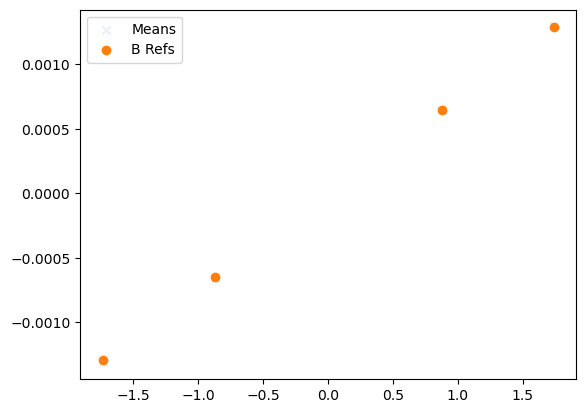

In [57]:
# Get the mean of measurements for each experiment and add it to a list
measured_means = []
for i in range(1,5):
    measured_mean = selected_df[selected_df['Experiment_Index'] == i]['Magnetic Field y (µT)'].mean()
    # measured_mean /= 10^6
    measured_means.append(measured_mean)
measured_means_in_T= [value / 1000000 for value in measured_means]
print(measured_means_in_T)

x = [1,2,3,4]
currents = [1.737, 0.874, -0.874, -1.737]

def B_ref(current):
    mu = 4 * np.pi * 10**(-7)
    N = 124
    R = 0.15
    return mu * (8*current*N) / (np.sqrt(125)*R)

brefs = []
for i in range(0,4):
    brefs.append(B_ref(currents[i]))
print(brefs)

plt.scatter(x=currents, y=measured_means_in_T, label='Means', marker='x', alpha=.1)
plt.scatter(x=currents, y=brefs, label='B Refs')
plt.legend()
plt.show()

In [39]:
# This cell is for analysis of the fit
slope, intercept = np.polyfit(currents, measured_means, 1)
predicted_y = slope * np.array(currents) + intercept
mean_y = np.mean(measured_means)
tss = np.sum((measured_means - mean_y) ** 2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((measured_means - predicted_y) ** 2)

# Calculate the coefficient of determination (R-squared)
r_squared = 1 - (rss / tss)

print("The r^2 value for the measurements is: ", r_squared)


The r^2 value for the measurements is:  0.9999990563736452
